#load library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler,quantile_transform,MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score

In [2]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


#load data & check data

In [3]:
train = pd.read_csv('/content/drive/MyDrive/problem_data/DPTCTR_PREDICT_TRAIN.csv',encoding='cp949')

test = pd.read_csv('/content/drive/MyDrive/problem_data/DPTCTR_PREDICT_TEST.csv',encoding='cp949')

In [4]:
train.head()

,cust_key,category_type,category_nm,count,dptctr_yn
0,711153,app,환율,27.0,0
1,867945,product,캐리어,2.0,1
2,225632,app,항공,2.0,1
3,882379,app,환전,3.0,0
4,815473,app,항공,11.0,0


In [5]:
train.shape

(727447, 5)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727447 entries, 0 to 727446
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   cust_key       727447 non-null  int64  
 1   category_type  727447 non-null  object 
 2   category_nm    727447 non-null  object 
 3   count          727447 non-null  float64
 4   dptctr_yn      727447 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 27.8+ MB


In [7]:
len(train['cust_key'].unique())

704304

In [8]:
train['category_type'].unique()

array(['app', 'product', 'online', 'keyword'], dtype=object)

In [9]:
train['category_nm'].unique()

array(['환율', '캐리어', '항공', '환전', '항공정보', '번역기', '번역', '면세점', '호텔', '기내용',
       '종합여행사', '국제결혼', '종합숙박예약', '여행기타', '숙박', '종합여행정보', '해외여행정보',
       '해외여행사', '청첩장', '지도', '테마여행사', '유학/어학연수', '해외종합대학교', '기타여행정보',
       '인터넷면세점', '이민', '웨딩컨설팅', '웨딩드레스', '신혼여행사', '환율 참고', '예식장',
       '웨딩스튜디오', '홈스테이', '여행관련기관/단체'], dtype=object)

# check unbalanced data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


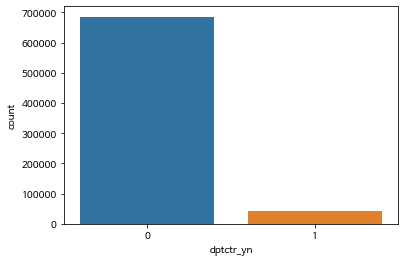

In [10]:
sns.countplot(train['dptctr_yn'])

In [11]:
train['dptctr_yn'].value_counts()

0    685667
1     41780
Name: dptctr_yn, dtype: int64

In [12]:
test.head()

,cust_key,category_type,category_nm,count
0,632813,app,환전,1.0
1,782389,app,환율,2.0
2,934290,app,환전,2.0
3,544805,app,환전,6.0
4,516180,app,번역,4.0


In [13]:
test.shape

(311764, 4)

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311764 entries, 0 to 311763
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   cust_key       311764 non-null  int64  
 1   category_type  311764 non-null  object 
 2   category_nm    311764 non-null  object 
 3   count          311764 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.5+ MB


In [15]:
len(test['cust_key'].unique())

306670

# check train & test data variable

In [16]:
for category_type,data in train.groupby(['category_type'])['category_nm']:
    
    print(category_type)
    print(data.unique())

app
['환율' '항공' '환전' '번역기' '번역' '숙박' '지도' '환율 참고']
keyword
['국제결혼' '캐리어' '기내용' '인터넷면세점' '예식장' '웨딩스튜디오' '홈스테이']
online
['항공정보' '면세점' '호텔' '종합여행사' '종합숙박예약' '여행기타' '종합여행정보' '해외여행정보' '해외여행사' '청첩장'
 '항공' '테마여행사' '유학/어학연수' '해외종합대학교' '기타여행정보' '이민' '웨딩컨설팅' '웨딩드레스' '신혼여행사'
 '여행관련기관/단체']
product
['캐리어' '기내용']


In [17]:
for category_type,data in test.groupby(['category_type'])['category_nm']:
    
    print(category_type)
    print(data.unique())

app
['환전' '환율' '번역' '항공' '번역기' '숙박' '지도' '환율 참고']
keyword
['인터넷면세점' '캐리어' '기내용' '국제결혼' '예식장' '웨딩스튜디오' '홈스테이']
online
['종합여행사' '항공' '호텔' '면세점' '해외여행정보' '종합여행정보' '해외여행사' '종합숙박예약' '여행기타' '항공정보'
 '청첩장' '이민' '신혼여행사' '해외종합대학교' '테마여행사' '유학/어학연수' '웨딩컨설팅' '기타여행정보' '웨딩드레스']
product
['캐리어' '기내용']


#drop train data

In [18]:
train[train['category_nm'] == '여행관련기관/단체']

,cust_key,category_type,category_nm,count,dptctr_yn
641274,309486,online,여행관련기관/단체,1.0,1


In [19]:
train.drop(641274,inplace=True)

In [20]:
train.reset_index(drop=True,inplace=True)

#create category variable

In [21]:
train['category'] = train['category_type'] + '_' + train['category_nm']

In [22]:
test['category'] = test['category_type'] + '_' + test['category_nm']

In [23]:
train.head()

,cust_key,category_type,category_nm,count,dptctr_yn,category
0,711153,app,환율,27.0,0,app_환율
1,867945,product,캐리어,2.0,1,product_캐리어
2,225632,app,항공,2.0,1,app_항공
3,882379,app,환전,3.0,0,app_환전
4,815473,app,항공,11.0,0,app_항공


In [24]:
test.head()

,cust_key,category_type,category_nm,count,category
0,632813,app,환전,1.0,app_환전
1,782389,app,환율,2.0,app_환율
2,934290,app,환전,2.0,app_환전
3,544805,app,환전,6.0,app_환전
4,516180,app,번역,4.0,app_번역


# EDA

In [25]:
train['count'].describe()

count    727446.000000
mean         13.660998
std          61.365388
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        6313.000000
Name: count, dtype: float64

In [26]:
test['count'].describe()

count    311764.00000
mean         13.54183
std          60.05062
min           1.00000
25%           1.00000
50%           3.00000
75%           8.00000
max        5788.00000
Name: count, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


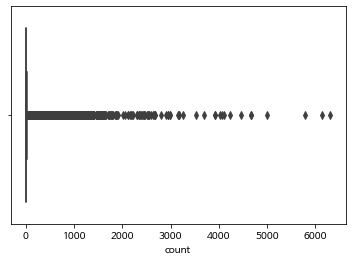

In [27]:
sns.boxplot(train['count'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


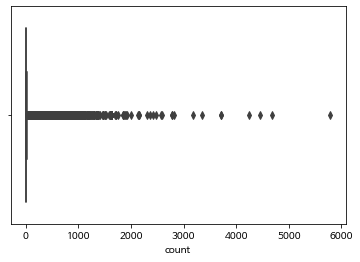

In [28]:
sns.boxplot(test['count'])

#create dummy variable

In [29]:
cat_train = train['category']

cat_test = test['category']

cat_train_dummies = pd.get_dummies(cat_train,drop_first=True)
cat_test_dummies = pd.get_dummies(cat_test,drop_first = True)

In [30]:
cat_train_dummies

,app_번역기,app_숙박,app_지도,app_항공,app_환율,app_환율 참고,app_환전,keyword_국제결혼,keyword_기내용,keyword_예식장,...,online_청첩장,online_테마여행사,online_항공,online_항공정보,online_해외여행사,online_해외여행정보,online_해외종합대학교,online_호텔,product_기내용,product_캐리어
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727441,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727442,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727443,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727444,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
cat_test_dummies

,app_번역기,app_숙박,app_지도,app_항공,app_환율,app_환율 참고,app_환전,keyword_국제결혼,keyword_기내용,keyword_예식장,...,online_청첩장,online_테마여행사,online_항공,online_항공정보,online_해외여행사,online_해외여행정보,online_해외종합대학교,online_호텔,product_기내용,product_캐리어
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311759,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311761,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311762,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#scaling continuous variable

In [32]:
scaler = StandardScaler()

con_train_scale = pd.DataFrame(scaler.fit_transform(train[['count']]),columns=['count'])

In [33]:
scaler = StandardScaler()

con_test_scale = pd.DataFrame(scaler.fit_transform(test[['count']]),columns=['count'])

In [34]:
con_train_scale.describe()

,count
count,7.274460e+05
mean,-9.328092e-18
std,1.000001e+00
min,-2.063216e-01
25%,-2.063216e-01
50%,-1.737299e-01
75%,-9.225072e-02
max,1.026530e+02


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


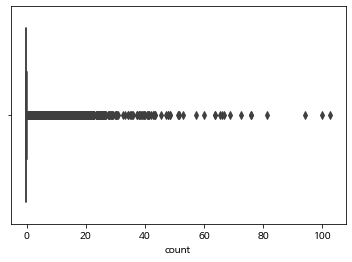

In [35]:
sns.boxplot(con_train_scale['count'])

In [36]:
con_train_trans = pd.DataFrame(quantile_transform(train[['count']],output_distribution = 'normal'),columns = ['count'])

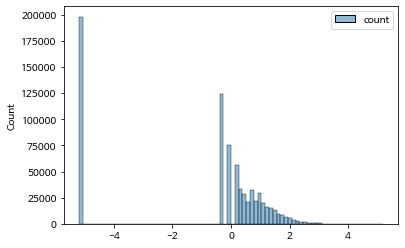

In [37]:
sns.histplot(con_train_trans)

In [38]:
con_train_trans.describe()

,count
count,727446.000000
mean,-1.085127
std,2.589948
min,-5.199338
25%,-5.199338
50%,-0.017565
75%,0.678433
max,5.199338


In [39]:
scaler = StandardScaler()

con_train_scale = pd.DataFrame(scaler.fit_transform(con_train_trans),columns=['count'])

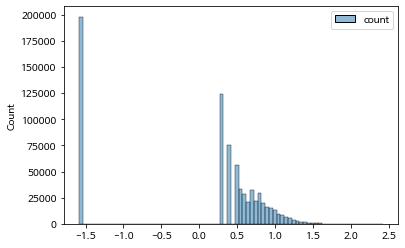

In [40]:
sns.histplot(con_train_scale)

In [41]:
con_train_scale.describe()

,count
count,7.274460e+05
mean,-1.270183e-16
std,1.000001e+00
min,-1.588531e+00
25%,-1.588531e+00
50%,4.121948e-01
75%,6.809252e-01
max,2.426484e+00


In [42]:
scaler = MinMaxScaler()

con_train_scale = pd.DataFrame(scaler.fit_transform(train[['count']]),columns=['count'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


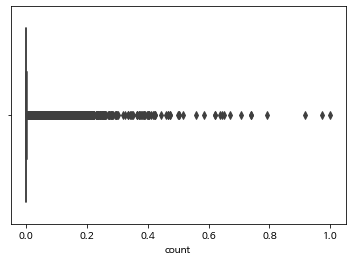

In [43]:
sns.boxplot(con_train_scale['count'])

In [44]:
con_train_trans = pd.DataFrame(quantile_transform(con_train_scale,output_distribution = 'normal'),columns = ['count'])

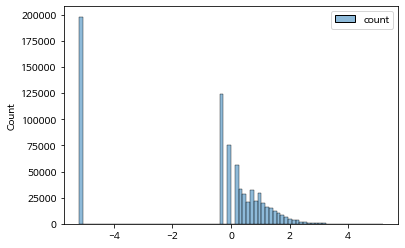

In [45]:
sns.histplot(con_train_trans)

In [46]:
con_train_trans = pd.DataFrame(quantile_transform(train[['count']],output_distribution = 'normal'),columns = ['count'])
con_test_trans = pd.DataFrame(quantile_transform(test[['count']],output_distribution='normal'),columns = ['count'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


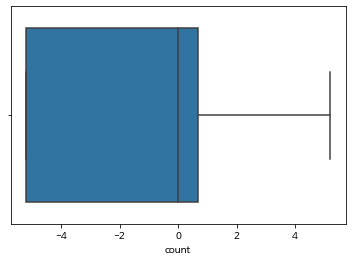

In [47]:
sns.boxplot(con_train_trans['count'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


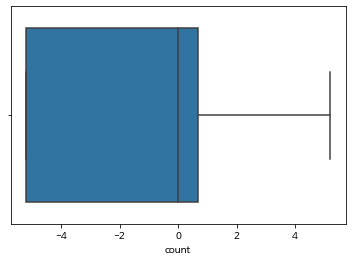

In [48]:
sns.boxplot(con_test_trans['count'])

# create final train & test data

In [49]:
train_data = pd.concat([con_train_trans,cat_train_dummies],axis = 1)

test_data = pd.concat([con_test_trans,cat_test_dummies],axis = 1)

In [50]:
train_data

,count,app_번역기,app_숙박,app_지도,app_항공,app_환율,app_환율 참고,app_환전,keyword_국제결혼,keyword_기내용,...,online_청첩장,online_테마여행사,online_항공,online_항공정보,online_해외여행사,online_해외여행정보,online_해외종합대학교,online_호텔,product_기내용,product_캐리어
0,1.352623,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.370902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.370902,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.017565,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.864365,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727441,1.664082,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727442,-0.017565,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
727443,-5.199338,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
727444,-0.370902,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
test_data

,count,app_번역기,app_숙박,app_지도,app_항공,app_환율,app_환율 참고,app_환전,keyword_국제결혼,keyword_기내용,...,online_청첩장,online_테마여행사,online_항공,online_항공정보,online_해외여행사,online_해외여행정보,online_해외종합대학교,online_호텔,product_기내용,product_캐리어
0,-5.199338,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.360172,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.360172,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.497809,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.217488,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311759,0.748009,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311760,0.497809,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311761,-5.199338,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311762,-0.360172,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
train_label = train['dptctr_yn']

# random split holdout validation

In [53]:
x_train,x_val,y_train,y_val = train_test_split(train_data,train_label,test_size=0.2, random_state=14)

In [54]:
x_train

,count,app_번역기,app_숙박,app_지도,app_항공,app_환율,app_환율 참고,app_환전,keyword_국제결혼,keyword_기내용,...,online_청첩장,online_테마여행사,online_항공,online_항공정보,online_해외여행사,online_해외여행정보,online_해외종합대학교,online_호텔,product_기내용,product_캐리어
216922,-5.199338,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
618032,-5.199338,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
541580,-0.370902,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
187253,0.912774,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
701961,0.678433,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306937,-5.199338,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
284999,0.216204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
641430,-5.199338,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
79192,1.352623,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
y_train

216922    0
618032    0
541580    0
187253    0
701961    0
         ..
306937    0
284999    1
641430    0
79192     0
117355    0
Name: dptctr_yn, Length: 581956, dtype: int64

In [56]:
x_val

,count,app_번역기,app_숙박,app_지도,app_항공,app_환율,app_환율 참고,app_환전,keyword_국제결혼,keyword_기내용,...,online_청첩장,online_테마여행사,online_항공,online_항공정보,online_해외여행사,online_해외여행정보,online_해외종합대학교,online_호텔,product_기내용,product_캐리어
159092,-0.370902,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
701968,1.215372,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372528,0.216204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78422,-5.199338,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
501018,-0.017565,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480172,0.499230,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
658760,-0.370902,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
215914,0.216204,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386172,-5.199338,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# lgb modeling

In [57]:
d_train = lgb.Dataset(x_train,label=y_train)
d_valid = lgb.Dataset(x_val,label=y_val)

In [58]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.6358813044063079, # 피처 샘플링 비율
    'bagging_fraction': 0.7019947002206903, # 데이터 샘플링 비율
    'bagging_freq': 4,
    'learning_rate':0.02179380661525133,
    'max_bin':242,
    'num_leaves':8,
    'min_data_in_leaf':13,
    'lambda_l1':4.2493201658954217e-07,
    'lambda_l2':4.122433613632396e-07,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': 32,
    'verbose': -1,
    'n_jobs': -1,    
}

In [59]:
clf = lgb.train(
            model_params,
            d_train,
            valid_sets=[d_train, d_valid],
            verbose_eval=200
        )

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.893972	valid_1's auc: 0.894033


In [60]:
val_probs = clf.predict(x_val)

val_preds = []

for prob in val_probs:

    if prob < 0.5:
        
        val_preds.append(0)
    
    else:
        
        val_preds.append(1)
    
val_preds = np.array(val_preds)

clf_f1_score = f1_score(y_val,val_preds)
clf_precision = precision_score(y_val,val_preds)
clf_recall = recall_score(y_val,val_preds)
clf_roc_auc = roc_auc_score(y_val,val_probs)
clf_acc = accuracy_score(y_val,val_preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


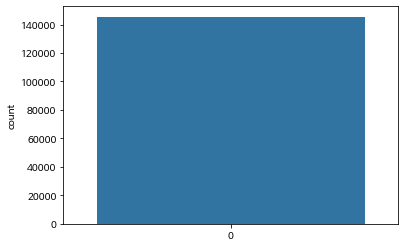

In [61]:
sns.countplot(val_preds)

# xgb modeling

In [62]:
d_train_xgb = xgb.DMatrix(x_train,label=y_train)
d_valid_xgb = xgb.DMatrix(x_val,label=y_val)
dlist = [(d_train_xgb, 'train'), (d_valid_xgb,'eval')]

In [63]:
model_params_xgb = {
    'objective': 'binary:logistic', # 이진 분류
    'eta': 0.01798811740179978,
    'gamma':4.71843869744652e-06,
    'lambda':0.00020474108445236137,
    'alpha':0.02412719930011848,
    'max_depth':3,
    'eval_metric': 'auc', # 평가 지표 설정
    'colsample_bytree': 0.6577690365339275, # 피처 샘플링 비율
    'subsample': 0.8551151322254398, # 데이터 샘플링 비율
    'seed': 89,
    'n_jobs': -1,    
}

In [64]:
# XGBoost 모델 훈련
clf2 = xgb.train(
    model_params_xgb,
    d_train_xgb,
    evals=dlist, # Validation 성능을 측정할 수 있도록 설정
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=200
)


[0]	train-auc:0.799423	eval-auc:0.7975
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[23]	train-auc:0.894949	eval-auc:0.895068



In [65]:
val_probs = clf2.predict(d_valid_xgb)

val_preds = []

for prob in val_probs:

    if prob < 0.5:
        
        val_preds.append(0)
    
    else:
        
        val_preds.append(1)
    
val_preds = np.array(val_preds)

clf2_f1_score = f1_score(y_val,val_preds)
clf2_precision = precision_score(y_val,val_preds)
clf2_recall = recall_score(y_val,val_preds)
clf2_roc_auc = roc_auc_score(y_val,val_probs)
clf2_acc = accuracy_score(y_val,val_preds)

# random forest modeling

In [66]:
model_params_rf = {
    'n_estimators':139,
    'max_depth':8,
    'random_state':30,
    'max_features': 0.41482207743803173,
    'max_leaf_nodes': 50,
    'verbose':-1,
    'n_jobs':-1
}

In [67]:
clf3 = RandomForestClassifier(**model_params_rf)

clf3.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  1.1min finished


RandomForestClassifier(max_depth=8, max_features=0.41482207743803173,
                       max_leaf_nodes=50, n_estimators=139, n_jobs=-1,
                       random_state=30, verbose=-1)

In [68]:
val_preds = clf3.predict(x_val)
val_probs = clf3.predict_proba(x_val)

clf3_f1_score = f1_score(y_val,val_preds)
clf3_precision = precision_score(y_val,val_preds)
clf3_recall = recall_score(y_val,val_preds)
clf3_roc_auc = roc_auc_score(y_val,val_probs[:,1])
clf3_acc = accuracy_score(y_val,val_preds)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 139 out of 139 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 139 out of 139 | elapsed:    1.1s finished


# validation model

In [69]:
print('lgb')
print({'f1':clf_f1_score,'precision':clf_precision,'recall':clf_recall,'auc':clf_roc_auc,'acc':clf_acc})

lgb
{'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.8940333549851452, 'acc': 0.9424908928448691}


In [70]:
print('xgb')
print({'f1':clf2_f1_score,'precision':clf2_precision,'recall':clf2_recall,'auc':clf2_roc_auc,'acc':clf2_acc})

xgb
{'f1': 0.5824947513212192, 'precision': 0.7387073081160485, 'recall': 0.4808174973108641, 'auc': 0.8922599268821888, 'acc': 0.9603615368753866}


In [71]:
print('rf')
print({'f1':clf3_f1_score,'precision':clf3_precision,'recall':clf3_recall,'auc':clf3_roc_auc,'acc':clf3_acc})

rf
{'f1': 0.590873496120168, 'precision': 0.7306338028169014, 'recall': 0.49599617545117725, 'auc': 0.8993217703490524, 'acc': 0.960499003367929}


# apply SMOTE

In [72]:
smote = SMOTE(random_state=0)

x_train_over,y_train_over = smote.fit_resample(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


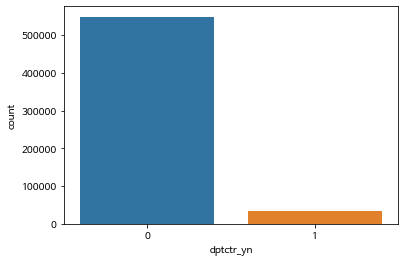

In [73]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


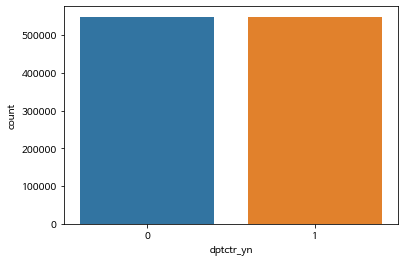

In [74]:
sns.countplot(y_train_over)

# SMOTE lgb modeling

In [75]:
d_train_over = lgb.Dataset(x_train_over,label=y_train_over)
d_valid = lgb.Dataset(x_val,label=y_val)

In [76]:
clf_over = lgb.train(
            model_params,
            d_train_over,
            valid_sets=[d_train_over, d_valid],
            verbose_eval=200
        )

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.89918	valid_1's auc: 0.897468
[400]	training's auc: 0.900267	valid_1's auc: 0.898345
[600]	training's auc: 0.900928	valid_1's auc: 0.899696
Early stopping, best iteration is:
[595]	training's auc: 0.900813	valid_1's auc: 0.899797


In [77]:
val_probs = clf_over.predict(x_val)

val_preds = []

for prob in val_probs:

    if prob < 0.5:
        
        val_preds.append(0)
    
    else:
        
        val_preds.append(1)
    
val_preds = np.array(val_preds)

clf_over_f1_score = f1_score(y_val,val_preds)
clf_over_precision = precision_score(y_val,val_preds)
clf_over_recall = recall_score(y_val,val_preds)
clf_over_roc_auc = roc_auc_score(y_val,val_probs)
clf_over_acc = accuracy_score(y_val,val_preds)

# SMOTE xgb modeling

In [78]:
d_train_over_xgb = xgb.DMatrix(x_train_over,label=y_train_over)
d_valid_xgb = xgb.DMatrix(x_val,label=y_val)
dlist = [(d_train_over_xgb, 'train'), (d_valid_xgb,'eval')]

In [79]:
clf2_over = xgb.train(
    model_params_xgb,
    d_train_over_xgb,
    evals=dlist, # Validation 성능을 측정할 수 있도록 설정
    num_boost_round=10000,
    early_stopping_rounds=100,
    verbose_eval=200
)


[0]	train-auc:0.792069	eval-auc:0.789845
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[200]	train-auc:0.898773	eval-auc:0.898534
[400]	train-auc:0.899776	eval-auc:0.89951
[600]	train-auc:0.900285	eval-auc:0.89967
[800]	train-auc:0.900557	eval-auc:0.899762
[1000]	train-auc:0.90078	eval-auc:0.899919
Stopping. Best iteration:
[933]	train-auc:0.90073	eval-auc:0.899942



In [80]:
val_probs = clf2_over.predict(d_valid_xgb)

val_preds = []

for prob in val_probs:

    if prob < 0.5:
        
        val_preds.append(0)
    
    else:
        
        val_preds.append(1)
    
val_preds = np.array(val_preds)

clf2_over_f1_score = f1_score(y_val,val_preds)
clf2_over_precision = precision_score(y_val,val_preds)
clf2_over_recall = recall_score(y_val,val_preds)
clf2_over_roc_auc = roc_auc_score(y_val,val_probs)
clf2_over_acc = accuracy_score(y_val,val_preds)

# SMOTE xgb modeling

In [81]:
clf3_over = RandomForestClassifier(**model_params_rf)

clf3_over.fit(x_train_over,y_train_over)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:  2.4min finished


RandomForestClassifier(max_depth=8, max_features=0.41482207743803173,
                       max_leaf_nodes=50, n_estimators=139, n_jobs=-1,
                       random_state=30, verbose=-1)

In [82]:
val_preds = clf3_over.predict(x_val)
val_probs = clf3_over.predict_proba(x_val)

clf3_over_f1_score = f1_score(y_val,val_preds)
clf3_over_precision = precision_score(y_val,val_preds)
clf3_over_recall = recall_score(y_val,val_preds)
clf3_over_roc_auc = roc_auc_score(y_val,val_probs[:,1])
clf3_over_acc = accuracy_score(y_val,val_preds)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 139 out of 139 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 139 out of 139 | elapsed:    1.2s finished


# validation SMOTE model

In [83]:
print('lgb_over')
print({'f1':clf_over_f1_score,'precision':clf_over_precision,'recall':clf_over_recall,'auc':clf_roc_auc,'acc':clf_over_acc})

lgb_over
{'f1': 0.4253298489387469, 'precision': 0.2899917430793968, 'recall': 0.7975379466953508, 'auc': 0.8940333549851452, 'acc': 0.8760602103237336}


In [84]:
print('xgb_over')
print({'f1':clf2_over_f1_score,'precision':clf2_over_precision,'recall':clf2_over_recall,'auc':clf2_roc_auc,'acc':clf2_over_acc})

xgb_over
{'f1': 0.42623579001149575, 'precision': 0.29081877205978474, 'recall': 0.797657463846062, 'auc': 0.8922599268821888, 'acc': 0.8765001030998694}


In [85]:
print('rf_over')
print({'f1':clf3_over_f1_score,'precision':clf3_over_precision,'recall':clf3_over_recall,'auc':clf3_roc_auc,'acc':clf3_over_acc})

rf_over
{'f1': 0.41004056485802304, 'precision': 0.27526617526617525, 'recall': 0.803394287080196, 'auc': 0.8993217703490524, 'acc': 0.8670492817375764}


#final model prediction

xgboost 모델이 SMOTE를 사용하고 사용하지 않고. 모든 경우에 5가지 지표에서 준수한 성능을 보이므로 xgboost 모델을 최종 모델로 선정

SMOTE를 쓰지 않았을 때 더 좋은 성능을 보이므로, SMOTE를 쓰지 않은 모델을 사용

# insight by using feature importance 

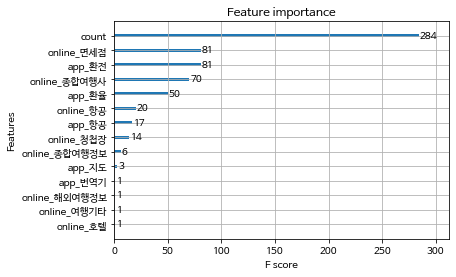

In [86]:
xgb.plot_importance(clf2)

관련 트래픽 수(count)가 출국여부에 가장 큰 영향을 미친다.

여기에 더하여 어떠한 주제가 출국여부에 영향을 미치는가?

온라인 면세점, 종합여행사, 항공 사이트를 방문하고, 환전,환율,항공 앱을 사용한 여부가 출국 여부에 영향을 미쳤다.

종합적으로는 온라인 면세점, 종합여행사, 항공 사이트를 많이 방문할수록, 환전,환율, 항공앱을 많이 설치하고 실행할수록 출국할 가능성이 높을 것이라고 생각할 수 있다.

#prediction test set using xgb model

In [88]:
d_test_xgb = xgb.DMatrix(test_data)

In [89]:
test_probs = clf2.predict(d_test_xgb)

test_preds = []

for prob in test_probs:

    if prob < 0.5:
        
        test_preds.append(0)
    
    else:
        
        test_preds.append(1)
    
test_preds = np.array(test_preds)

In [97]:
test = pd.read_csv('/content/drive/MyDrive/problem_data/DPTCTR_PREDICT_TEST.csv',encoding='cp949')

test['dptcrt_yn'] = test_preds

test.to_csv('output.csv',encoding='cp949')